<a href="https://colab.research.google.com/github/Explorer9/INFO5731_FALL2020/blob/master/In_Class_exercises_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In class exercise 10

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The purpose of the exercise is to practice different machine learning algorithms for text clustering
Please downlad the dataset by using the following link.  https://www.kaggle.com/PromptCloudHQ/amazon-reviews-unlocked-mobile-phones
(You can also use different text data which you want)

Apply the listed clustering methods to the dataset:

K means, 
DBSCAN,
Hierarchical clustering. 

You can refer to of the codes from  the follwing link below. 
https://www.kaggle.com/karthik3890/text-clustering 
    

In [64]:
#Write your code here.
import pandas as pd
import gensim
df=pd.read_csv("/content/drive/MyDrive/Amazon_Unlocked_Mobile.csv")
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from textblob import Word
nltk.download('wordnet')
from nltk.stem import PorterStemmer
st = PorterStemmer()
df = df[df['Reviews'].notnull()]
stop = stopwords.words('english')
df['after_punct_less'] = df['Reviews'].str.replace('[^\w\s].#','')
df['after_rm_stopwords'] =df['after_punct_less'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['after_numerics']=df['after_rm_stopwords'].str.replace('[0-9]','')
df['after_lowercasing'] =df['after_numerics'].apply(lambda x: " ".join(x.lower() for x in x.split()))

df['after_stemming']=df['after_lowercasing'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
df['cleaned_text'] = df['after_stemming'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
df['cleaned_text'].head()

0    i feel lucki found use (phone u & use hard all...
1    nice phone, nice grade pantach revue. veri cle...
2                                            veri plea
3      it work good goe slow sometim good phone i love
4    great phone replac lost phone. the thing volum...
Name: cleaned_text, dtype: object

In [7]:
df_1=(df.sample(n=4000)).reset_index() #10% random sample of the dataset 

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer()
tfidf = tfidf_vect.fit_transform(df_1['cleaned_text'].values)
tfidf.shape

(4000, 7143)

Kmeans clustering

In [12]:

from sklearn.cluster import KMeans
model_tf = KMeans(n_clusters = 5, n_jobs = -1,random_state=99)
model_tf.fit(tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=99, tol=0.0001, verbose=0)

In [13]:
labels_tf = model_tf.labels_
cluster_center_tf=model_tf.cluster_centers_

In [20]:
# to understand what kind of words generated as columns by BOW
terms1 = tfidf_vect.get_feature_names()
terms1[1:5]
df1 = df_1
df1['Tfidf Clus Label'] = model_tf.labels_
df1.head(5)

,index,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,after_punct_less,after_rm_stopwords,after_numerics,after_lowercasing,after_stemming,cleaned_text,Tfidf Clus Label
0,73510,Apple iPhone 7 Unlocked Phone 256 GB - US Vers...,Apple,949.95,5,Good,0.0,Good,Good,Good,good,good,good,3
1,404117,Unlocked Quadband Dual Sim Android 4.0 Os A710...,OceanCross,39.99,1,I wish Amazon had a negative star option. I ne...,6.0,I wish Amazon had a negative star option. I ne...,I wish Amazon negative star option. I never li...,I wish Amazon negative star option. I never li...,i wish amazon negative star option. i never li...,i wish amazon neg star option. i never like gi...,i wish amazon neg star option. i never like gi...,0
2,124033,Blu LIFE 8 Unlocked (White),BLU,169.99,5,I just received my BLU Life 8 this past Saturd...,3.0,I just received my BLU Life 8 this past Saturd...,I received BLU Life 8 past Saturday (January 3...,"I received BLU Life past Saturday (January , ...","i received blu life past saturday (january , )...","i receiv blu life past saturday (januari , ) f...","i receiv blu life past saturday (januari , ) f...",0
3,1647,"Alcatel One Touch Fierce 2, 4GB, 5"" Screen, Un...",Alcatel,118.99,5,very good cellphone!,0.0,very good cellphone!,good cellphone!,good cellphone!,good cellphone!,good cellphone!,good cellphone!,3
4,373771,Samsung Galaxy S7 Edge SM-G935F 32GB Factory U...,NaN,591.00,5,Sleek phone. Looks great! A good size not too ...,0.0,Sleek phone. Looks great! A good size not too ...,Sleek phone. Looks great! A good size large. F...,Sleek phone. Looks great! A good size large. F...,sleek phone. looks great! a good size large. f...,sleek phone. look great! a good size large. fi...,sleek phone. look great! a good size large. fi...,0


In [22]:
df1.groupby(['Tfidf Clus Label'])['cleaned_text'].count()

Tfidf Clus Label
0    3258
1     185
2     129
3     193
4     235
Name: cleaned_text, dtype: int64

In [29]:
print("Top terms per cluster:")
order_centroids = model_tf.cluster_centers_.argsort()[:, ::-1]
for i in range(1,5):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :5]:
        print(' %s' % terms1[ind], end='')
        print()

Top terms per cluster:
Cluster 1: great
 phone
 work
 product
 price
Cluster 2: excel
 product
 phone
 recommend
 thank
Cluster 3: good
 veri
 price
 phone
 product
Cluster 4: love
 perfect
 it
 phone
 great


DBSCAN

In [62]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import gensim

In [67]:
i=0
list_of_sent=[]
for sent in df_1['cleaned_text'].values:
    list_of_sent.append(sent.split())

In [71]:
w2v_model=gensim.models.Word2Vec(list_of_sent,size=100, workers=4)
import numpy as np
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this train
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
sent_vectors = np.array(sent_vectors)
sent_vectors = np.nan_to_num(sent_vectors)
sent_vectors.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  


(4000, 100)

In [72]:
# Computing 200th Nearest neighbour distance
minPts = 2 * 100
# Lower bound function copied from -> https://gist.github.com/m00nlight/0f9306b4d4e61ba0195f
def lower_bound(nums, target): # This function return the number in the array just greater than or equal to itself.
    l, r = 0, len(nums) - 1
    while l <= r: # Binary searching.
        mid = int(l + (r - l) / 2)
        if nums[mid] >= target:
            r = mid - 1
        else:
            l = mid + 1
    return l

def compute200thnearestneighbour(x, data): # Returns the distance of 200th nearest neighbour.
    dists = []
    for val in data:
        dist = np.sum((x - val) **2 ) # computing distances.
        if(len(dists) == 200 and dists[199] > dist): # If distance is larger than current largest distance found.
            l = int(lower_bound(dists, dist)) # Using the lower bound function to get the right position.
            if l < 200 and l >= 0 and dists[l] > dist:
                dists[l] = dist
        else:
            dists.append(dist)
            dists.sort()
    
    return dists[199] # Dist 199 contains the distance of 200th nearest neighbour.

In [73]:
twohundrethneigh = []
for val in sent_vectors[:1500]:
    twohundrethneigh.append( compute200thnearestneighbour(val, sent_vectors[:1500]) )
twohundrethneigh.sort()

In [50]:
mob_vectors.shape

(4000, 100)

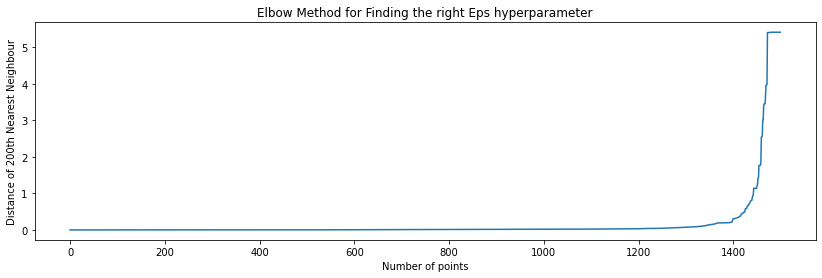

In [74]:
plt.figure(figsize=(14,4))
plt.title("Elbow Method for Finding the right Eps hyperparameter")
plt.plot([x for x in range(len(twohundrethneigh))], twohundrethneigh)
plt.xlabel("Number of points")
plt.ylabel("Distance of 200th Nearest Neighbour")
plt.show()


In [76]:
# Training DBSCAN :
model = DBSCAN(eps = 5, min_samples = minPts, n_jobs=-1)
model.fit(sent_vectors)
df_1['AVG-W2V Clus Label'] = model.labels_
df_1.head(2)

,index,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,after_punct_less,after_rm_stopwords,after_numerics,after_lowercasing,after_stemming,cleaned_text,Tfidf Clus Label,AVG-W2V Clus Label
0,73510,Apple iPhone 7 Unlocked Phone 256 GB - US Vers...,Apple,949.95,5,Good,0.0,Good,Good,Good,good,good,good,3,0
1,404117,Unlocked Quadband Dual Sim Android 4.0 Os A710...,OceanCross,39.99,1,I wish Amazon had a negative star option. I ne...,6.0,I wish Amazon had a negative star option. I ne...,I wish Amazon negative star option. I never li...,I wish Amazon negative star option. I never li...,i wish amazon negative star option. i never li...,i wish amazon neg star option. i never like gi...,i wish amazon neg star option. i never like gi...,0,0


Hierarchial clustering

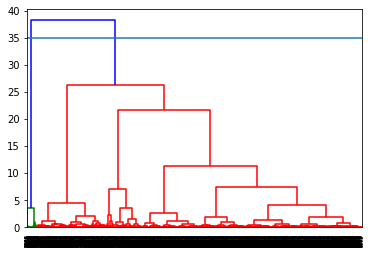

In [77]:
import scipy
from scipy.cluster import hierarchy
dendro=hierarchy.dendrogram(hierarchy.linkage(sent_vectors,method='ward'))
plt.axhline(y=35)# cut at 30 to get 5 clusters

In [79]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  #took n=5 from dendrogram curve 
Agg=cluster.fit_predict(sent_vectors)

In [82]:
df_1['AVG-W2V Clus Label'] = cluster.labels_
df_1.head(2)
df_1.groupby(['AVG-W2V Clus Label'])['cleaned_text'].count()

AVG-W2V Clus Label
0    1946
1     431
2     832
3     117
4     674
Name: cleaned_text, dtype: int64

In [84]:
# Reading a review which belong to each group.
for i in range(5):
    print("2 reviews of assigned to cluster ", i)
    print("-" * 70)
    print(df_1.iloc[df_1.groupby(['AVG-W2V Clus Label']).groups[i][0]]['cleaned_text'])
    print('\n')
    print(df_1.iloc[df_1.groupby(['AVG-W2V Clus Label']).groups[i][1]]['cleaned_text'])
    print('\n')
    print("_" * 70)

2 reviews of assigned to cluster  0
----------------------------------------------------------------------
i wish amazon neg star option. i never like give bad review product ridiculous. first phone could bare read sim card slots. i chang sim card sure someth wrong sim card. than mic went bad one hear me. not mention headphon work. the worst part i travel use product oversea thu miss deadline.


i receiv blu life past saturday (januari , ) far i extrem satisfied. i previous use iphon screen burn i want dish dollar unlock iphon . i use android phone iphon transfer app phone previou dormant googl play account amazingli simpl fast. i want good android phone i actual miss android os, anyth wrong iphon o doesn’t come across smooth user friendli android system.mi blu life hous within week place order. thi phone ship android kit kat (just time lollipop released). that plenti quick enough me. so far good blu life . it instantli lock home wi-fi minut i rang (which mean i pull driveway), coupl v

In one paragraph, please compare K means, DBSCAN and Hierarchical clustering. 

In [ ]:
#You can write you answer here.
K-means clustering is widely used clustering and it works even for large datasets effeciently, but it as a generalised models and it works well if performed for more number of iterations, 
and K-means is easy to understand with just a cluster with cluster of elements, K-means clustering will not work well when there is MISSING data and if there are any outliers in the dataset, 
where DBSCAN works on desnity so it can handle outliers and missing data in the dataset, as it is based on density it may not work for sparse datasets where density is varies, 
Hierarchial clustering may not work as good as k-means but it works with any type of data and is used in a special purpose where we need to find the hierarchies in the clusters.
As we can see in the above example of hierachial clustering, clustering is perfromed with the full text and each cluster represents the sentences either with positive sense or negative sense but not both.   
